In [1]:
import keras
from keras.models import Model, Input
from keras.layers import Conv2D, Activation, MaxPool2D, Flatten, Dense
from keras.layers import BatchNormalization

from keras.datasets import mnist
from keras.optimizers import SGD
from keras.utils import to_categorical
import numpy as np
from numpy.random import seed

seed(42)

import time

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Magic numbers

In [2]:
nb_classes=10
optim = SGD()
pix_ox, pix_oy = (28, 28)

epochs = 10
batch_size = 128


# Load the dataset

In [3]:
print(mnist.__file__)

/usr/local/lib/python3.6/site-packages/keras/datasets/mnist.py


# Import the dataset

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


# Reshape data to 4D sensors

In [6]:
x_train = np.reshape(x_train, (-1, pix_ox, pix_oy,1))
x_test = np.reshape(x_test, (-1, pix_ox, pix_oy,1))
print(x_train.shape)
print(x_test.shape)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


# Ensure float

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


# Normalize the data

In [8]:
x_train = x_train / 255.
x_test = x_test / 255.


# One hot encoding

In [9]:
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

print(y_train[544])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# The model

In [10]:
def my_model(input_value):
  # normalize
  # x = BatchNormalization(x)
  x = Conv2D(filters=32,  kernel_size=(5,5), 
             strides=(1,1), 
             padding='same')(input_value)
  x = Activation('relu')(x)
  x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)

  x = Conv2D(filters=64,  kernel_size=(3,3), 
             strides=(1,1), 
             padding='same')(x)
  x = Activation('relu')(x)
  x = MaxPool2D(pool_size=(2,2), strides=(1,1), padding='valid')(x)

  x = Conv2D(filters=64, 
             kernel_size=(3,3), 
             strides=(1,1), 
             padding='same')(x)
  x = Activation('relu')(x)
  x = MaxPool2D(pool_size=(2,2), strides=(1,1), padding='valid')(x)
  
  x = Flatten()(x)
  x = Dense(nb_classes, activation='softmax')(x)

  return x
  

# Functional API

In [11]:
inputs = Input((pix_ox, pix_oy, 1))
out = my_model(inputs)

model = Model(inputs=inputs, outputs=out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
__________

# Compile

In [12]:
model.compile(loss='categorical_crossentropy', 
              optimizer=optim, metrics=['accuracy'])

# Callbacks

In [13]:
class PlotLossesDuringTraining(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.logs = []
    self.losses = []
    self.test_losses = []
    
    self.plot = plt.figure()
    
    
  def on_epoch_end(self, epoch, logs={}):
    self.x.append(self.i)
    self.logs.append(logs)
    self.losses.append(logs.get('loss'))
    self.test_losses.append(logs.get('val_loss'))
    
    plt.plot(self.x, self.losses, label='train')
    plt.plot(self.x, self.test_losses, label='test')
    plt.legend()
    plt.show()
    
    self.i += 1

losses_train = PlotLossesDuringTraining()

# Train

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 79s 1ms/step - loss: 0.7960 - acc: 0.7705 - val_loss: 0.2232 - val_acc: 0.9309


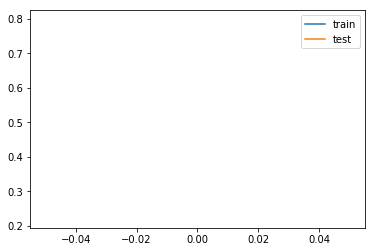

Epoch 2/10
60000/60000 [==============================] - 80s 1ms/step - loss: 0.1742 - acc: 0.9487 - val_loss: 0.1163 - val_acc: 0.9678


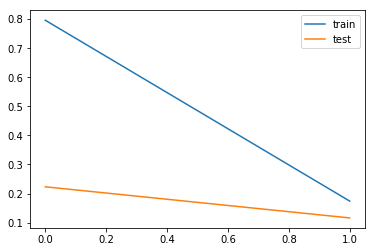

Epoch 3/10
60000/60000 [==============================] - 81s 1ms/step - loss: 0.1162 - acc: 0.9654 - val_loss: 0.0944 - val_acc: 0.9697


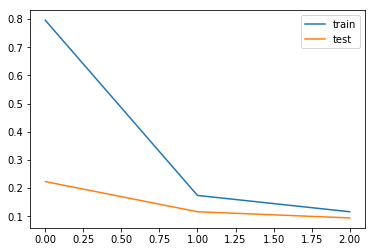

Epoch 4/10
34816/60000 [================>.............] - ETA: 31s - loss: 0.0936 - acc: 0.9717

KeyboardInterrupt: 

In [14]:
start_time = time.time()
model.fit(x_train, y_train, 
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(x_test, y_test),
          callbacks=[losses_train],
          verbose=1)
elapsed_duration = time.time() - start_time

print("Training time", elapsed_duration)
